# Data Preprocessing

## Note on Onehot Encoding

To prevent cluttering the database with several extra columns (and thus making it harder to maintain) the data will not be onehot encoded at this point. Instead onehot encoding will be applied to the dataset on demand by the ML service when requested.

This applies to the following columns:
 - AccidentType
 - Dominant injury
 - Vehicle Type
 - Weather Conditions
 - Accident Description
 - Injury Description
 - Gender

## Initial Data

In [13]:
import pandas as pd
import seaborn as sns
import datetime

In [2]:
claimData = pd.read_csv('dataset/Synthetic_Data_For_Students.csv')

In [3]:
pd.set_option('display.max_columns', None)  
print(claimData.columns)
print(claimData)

Index(['SettlementValue', 'AccidentType', 'Injury_Prognosis',
       'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage',
       'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss',
       'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage',
       'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed',
       'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts',
       'SpecialJourneyExpenses', 'SpecialTherapy', 'Exceptional_Circumstances',
       'Minor_Psychological_Injury', 'Dominant injury', 'Whiplash',
       'Vehicle Type', 'Weather Conditions', 'Accident Date', 'Claim Date',
       'Vehicle Age', 'Driver Age', 'Number of Passengers',
       'Accident Description', 'Injury Description', 'Police Report Filed',
       'Witness Present', 'Gender'],
      dtype='object')
      SettlementValue                             AccidentType  \
0              520.00                                 Rear end   
1              870.00                     

## Handling Missing Data

### Removing Missing Values

Since the settlement value is what's being predicted, any row with a null settlement value is invalid

In [4]:
removableValueColumns = []
removableValueColumns.append('SettlementValue')

All values in injury prognosis have an associated letter code, since there is no provided letter code for missing/0 month prognoses there is no valid default value so any data rows with a missing prognosis is removed.

In [5]:
removableValueColumns.append('Injury_Prognosis')

Dates and ages dont have good default values so they're removed. For number of passengers, while 1 seems a sensible default, this isn't necessarily a valid inference and is therefore removed.

In [6]:
removableValueColumns.append('Accident Date')
removableValueColumns.append('Claim Date')
removableValueColumns.append('Number of Passengers')
removableValueColumns.append('Driver Age')
removableValueColumns.append('Vehicle Age')

In [7]:
for rowIndex, rowData in claimData.iterrows():
    for col in removableValueColumns:
        if pd.isna(rowData[col]):
            claimData.drop(index=rowIndex, inplace=True)
            break

In [8]:
claimData.reset_index(drop=True, inplace=True)    

print(claimData.isnull().any(axis = 1).sum())
print(len(claimData))

752
4297


### Replace Missing Values

The following columns all represent monetary values. A missing value is interpreted as no value and thus they are defaulted to 0.

In [9]:
defaultZeroColumns = ['SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage',
                      'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss',
                      'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage',
                      'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed',
                      'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts',
                      'SpecialJourneyExpenses', 'SpecialTherapy']

for rowIndex, rowData in claimData.iterrows():
    for col in defaultZeroColumns:
        if pd.isna(rowData[col]):
            claimData.at[rowIndex, col] = 0
            
print(claimData.isnull().any(axis = 1).sum())

429


The following columns are all boolean values. A missing value here is interpreted as false.

In [10]:
defaultNoColumns = ['Exceptional_Circumstances', 'Minor_Psychological_Injury', 'Whiplash', 'Police Report Filed', 'Witness Present']

for rowIndex, rowData in claimData.iterrows():
    for col in defaultNoColumns:
        if pd.isna(rowData[col]):
            claimData.at[rowIndex, col] = "No"

In [11]:
print(claimData.isnull().any(axis = 1).sum())

325


### Remaining Missing Values

Any missing values that haven't been handled so far are in columns that will later be one hot encoded at which point the missing value will no longer be an issue as it will instead be represented by a 0 across all relevant onehot columns.

## Data Visualization

In our dataset we have two protected characteristics:
- Age
- Gender

We can plot these columns to visualise how the data is distributed and if it is representative/ balanced.

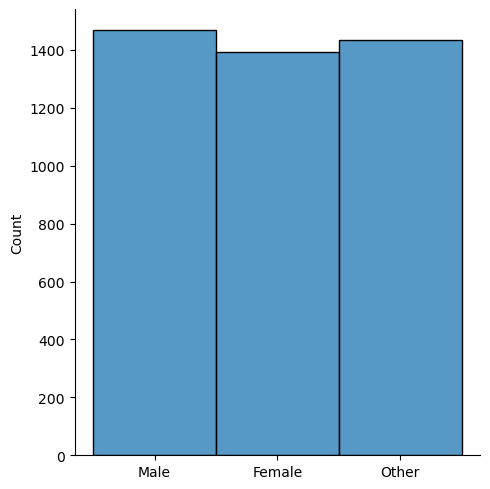

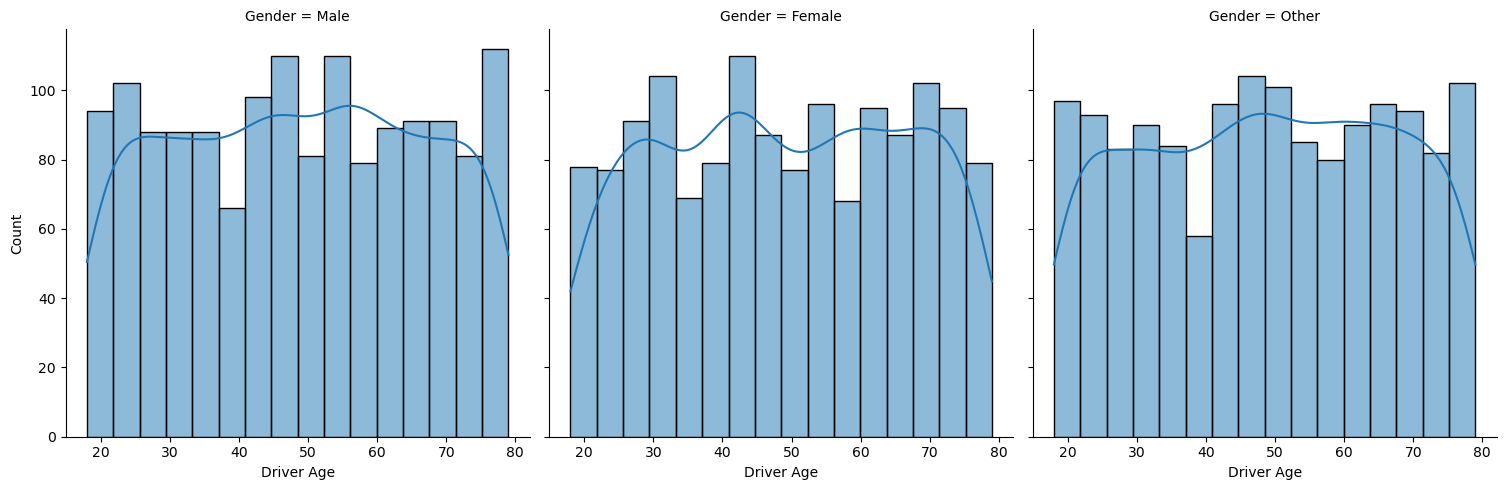

In [28]:
sns.displot(claimData['Gender'].to_numpy())
sns.displot(data=claimData, x="Driver Age", col="Gender", kde=True, col_wrap=4)

We have a good balance of sample size across gender. With only slightly more male than other categories.

We also have a good distribution of age representation within these groups.

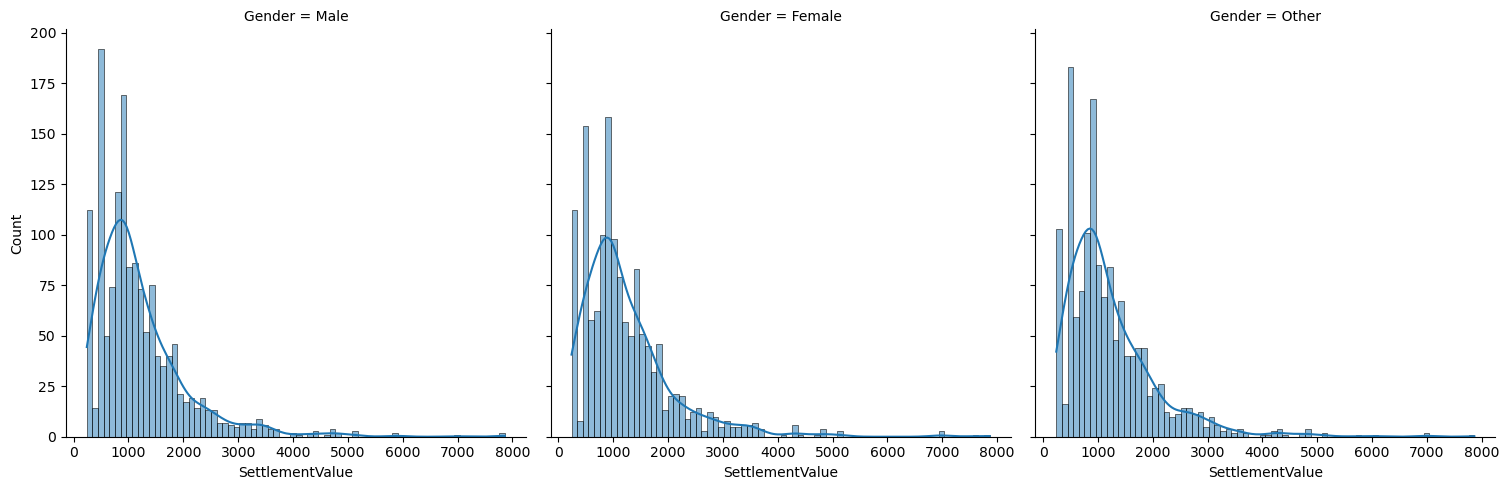

In [29]:
sns.displot(data=claimData, x="SettlementValue", col="Gender", kde=True, col_wrap=4)

## Reducing Accuracy

Accident date and claim date are both recorded down to the millisecond which is far more accurate than is reasonably possible or necessary. Furthermore, since the time value for is identical across both fields it is likely that it was added automatically and/or by mistake.

In [12]:
for rowIndex, rowData in claimData.iterrows():
    # The date portion of the data is always the first 10 characters
    accidentDateOnly = rowData["Accident Date"][:10]
    claimDateOnly = rowData["Claim Date"][:10]
    
    claimData.at[rowIndex, "Accident Date"] = accidentDateOnly
    claimData.at[rowIndex, "Claim Date"] = claimDateOnly
    
print(claimData[["Accident Date", "Claim Date"]])

     Accident Date  Claim Date
0       2023-11-10  2024-06-11
1       2023-06-25  2024-01-09
2       2020-02-23  2020-03-01
3       2021-10-02  2021-10-13
4       2023-04-02  2023-04-14
...            ...         ...
4292    2022-09-14  2023-08-14
4293    2021-08-25  2022-06-30
4294    2023-03-09  2023-08-05
4295    2023-02-09  2023-10-18
4296    2020-04-09  2020-06-05

[4297 rows x 2 columns]


## Data Types

Currently the injury prognosis is stored as a string in the format "X months" and preceded by a letter code. The letter code and "months" text is completely unnecessary and thus are being removed and the field converted to an integer representing the prognosis in months.

In [13]:
i = 0
for cellData in claimData["Injury_Prognosis"]:
    months = int(''.join(c for c in cellData if c.isdigit()))
    claimData.at[i, "Injury_Prognosis"] = months
    i += 1
    
print(claimData["Injury_Prognosis"])

0        5
1        2
2        7
3        4
4        3
        ..
4292     4
4293     1
4294     6
4295     4
4296    11
Name: Injury_Prognosis, Length: 4297, dtype: object


There are several columns which only contain "Yes" or "No" and as such are better represented boolean or binary values.

In [14]:
binaryCols = defaultNoColumns

for col in binaryCols:
    i = 0
    for cellData in claimData[col]:
        val = 1 if cellData == "Yes" else 0
        claimData.at[i, col] = val
        i += 1
        
print(claimData[binaryCols])

     Exceptional_Circumstances Minor_Psychological_Injury Whiplash  \
0                            0                          1        1   
1                            0                          1        1   
2                            0                          0        1   
3                            0                          1        1   
4                            0                          1        0   
...                        ...                        ...      ...   
4292                         0                          1        0   
4293                         0                          1        0   
4294                         0                          1        0   
4295                         0                          1        0   
4296                         0                          1        1   

     Police Report Filed Witness Present  
0                      1               1  
1                      1               1  
2                      1      

In order for an AI to properly train on and understand a date, we need to convert it to a numerical value first, such as unix time or in our case (since we are using date only) julian date.

In [15]:
for rowIndex, rowData in claimData.iterrows():
    accidentDate = rowData["Accident Date"]
    claimDate = rowData["Claim Date"]
    
    accidentDate = datetime.datetime.strptime(accidentDate, '%Y-%m-%d')
    accidentJulianDay = accidentDate.strftime('%j')
    accidentJulianDate = int(f"{accidentDate.year}{accidentJulianDay}")
    
    claimDate = datetime.datetime.strptime(claimDate, '%Y-%m-%d')
    claimJulianDay = claimDate.strftime('%j')
    claimJulianDate = int(f"{accidentDate.year}{claimJulianDay}")
    
    claimData.at[rowIndex, "Accident Date"] = accidentJulianDate
    claimData.at[rowIndex, "Claim Date"] = claimJulianDate
    
print(claimData[["Accident Date", "Claim Date"]])

     Accident Date Claim Date
0          2023314    2023163
1          2023176    2023009
2          2020054    2020061
3          2021275    2021286
4          2023092    2023104
...            ...        ...
4292       2022257    2022226
4293       2021237    2021181
4294       2023068    2023217
4295       2023040    2023291
4296       2020100    2020157

[4297 rows x 2 columns]


In [16]:
claimData.convert_dtypes().dtypes

SettlementValue               Float64
AccidentType                   string
Injury_Prognosis                Int64
SpecialHealthExpenses           Int64
SpecialReduction                Int64
SpecialOverage                Float64
GeneralRest                   Float64
SpecialAdditionalInjury       Float64
SpecialEarningsLoss           Float64
SpecialUsageLoss                Int64
SpecialMedications            Float64
SpecialAssetDamage            Float64
SpecialRehabilitation         Float64
SpecialFixes                  Float64
GeneralFixed                    Int64
GeneralUplift                 Float64
SpecialLoanerVehicle          Float64
SpecialTripCosts              Float64
SpecialJourneyExpenses        Float64
SpecialTherapy                Float64
Exceptional_Circumstances       Int64
Minor_Psychological_Injury      Int64
Dominant injury                string
Whiplash                        Int64
Vehicle Type                   string
Weather Conditions             string
Accident Dat

## Column Names

Column names in the dataset use varying naming conventions including PascalCase, Snake_Case and some are simply written with spaces. The database being used has all column names in PascalCase so for clarity and consistency all columns in the dataset will be converted. 

In [17]:
columnRenameDict = {
    "Injury_Prognosis":"InjuryPrognosis",
    "Exceptional_Circumstances":"ExceptionalCircumstances",
    "Minor_Psychological_Injury":"MinorPsychologicalInjury",
    "Dominant injury":"DominantInjury",
    "Vehicle Type":"VehicleType",
    "Weather Conditions":"WeatherConditions",
    "Accident Date":"AccidentDate",
    "Claim Date":"ClaimDate",
    "Vehicle Age":"VehicleAge",
    "Driver Age":"DriverAge",
    "Number of Passengers":"NumberOfPassengers",
    "Accident Description":"AccidentDescription",
    "Injury Description":"InjuryDescription",
    "Police Report Filed":"PoliceReportFiled",
    "Witness Present":"WitnessPresent"
}

claimData = claimData.rename(columns=columnRenameDict)
print(claimData.columns)

Index(['SettlementValue', 'AccidentType', 'InjuryPrognosis',
       'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage',
       'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss',
       'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage',
       'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed',
       'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts',
       'SpecialJourneyExpenses', 'SpecialTherapy', 'ExceptionalCircumstances',
       'MinorPsychologicalInjury', 'DominantInjury', 'Whiplash', 'VehicleType',
       'WeatherConditions', 'AccidentDate', 'ClaimDate', 'VehicleAge',
       'DriverAge', 'NumberOfPassengers', 'AccidentDescription',
       'InjuryDescription', 'PoliceReportFiled', 'WitnessPresent', 'Gender'],
      dtype='object')


In [18]:
claimData.to_csv('ProcessedClaimData.csv', index=False)